In [1]:
import os
from itertools import product
from functools import partial

import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm

from src.loss_functions import FourthOrder
from src.optimizers import Sgd, Ig, Shuffling, ClippedShuffling, \
    ClERR, ClERR2
from src.optimizers.stochastic_optimizer import StochasticOptimizer
from src.optimizers.traces import StochasticTrace
from src.utils import get_trace, relative_round
%load_ext autoreload
%autoreload 2

sns.set(style="whitegrid", font_scale=1.2, context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['figure.figsize'] = (8, 6)

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
.jupyter-widgets {color: #d5d5d5 !important;}
.widget-label {color: #d5d5d5 !important;}
</style>


# Additional functions

In [3]:
def best_trace_by_step_size(traces, step_size_list):
    min_i, min_val = 0, np.inf
    for i, tr in enumerate(traces):
        if tr.loss_vals is None:
            mean_loss_val = 0
            for loss_vals in tr.loss_vals_all.values():
                # last_half = loss_vals[-len(loss_vals) // 2:]
                # mean_loss_val += np.mean(last_half)
                last_part = loss_vals[-len(loss_vals) // 5:]
                mean_loss_val += np.mean(last_part)
            mean_loss_val /= len(tr.loss_vals_all)
        else:
            # last_half = loss_vals[-len(tr.loss_vals) // 2:]
            # mean_loss_val = np.mean(last_half)
            last_part = loss_vals[-len(tr.loss_vals) // 5:]
            mean_loss_val = np.mean(last_part)
        if mean_loss_val < min_val:
            min_val = mean_loss_val
            min_i = i
    
    best_trace = traces[min_i]
    best_trace.step_size = step_size_list[min_i]
    return best_trace

In [4]:
def best_trace_by_lr_and_cl(alg_type, trace_dir, n_epochs, loss, step_size_list, clip_level_list, in_step_size=None):
    min_val = np.inf
    best_trace = None
    is_any_trace = False
    for step_size, clip_level in product(step_size_list, clip_level_list):
        if alg_type == 'crr':
            fn = f"c_{clip_level}_lr_{step_size}_rr_{n_epochs}"
        elif alg_type == 'so':
            fn = f"so_lr_{step_size}_{n_epochs}"
        elif alg_type == 'gd':
            fn = f"c_{clip_level}_lr_{step_size}_gd_{n_epochs}"
        elif alg_type == 'nastya':
            assert in_step_size is not None
            fn = f"nastya_lr_{step_size}_in_lr_{in_step_size}_{n_epochs}"
        elif alg_type == 'clerr':
            assert in_step_size is not None
            fn = f"clerr_c_{clip_level}_lr_{step_size}_in_lr_{in_step_size}_{n_epochs}"
        elif alg_type == 'clerr_g':
            assert in_step_size is not None
            fn = f"clerr_g_c_{clip_level}_lr_{step_size}_in_lr_{in_step_size}_{n_epochs}"
        elif alg_type == 'clerr_2':
            assert in_step_size is not None
            fn = f"clerr_2_c_{clip_level}_lr_{step_size}_in_lr_{in_step_size}_{n_epochs}"
        elif alg_type == 'clerr_2_g':
            assert in_step_size is not None
            fn = f"clerr_2_g_c_{clip_level}_lr_{step_size}_in_lr_{in_step_size}_{n_epochs}"
        else:
            raise NotImplementedError(f'{alg_type} is not implemented!')

        trace_path = os.path.join(trace_dir, fn)
        best_trace, min_val = update_best_trace(
            best_trace,
            min_val,
            trace_path,
            loss,
            alg_type,
            step_size,
            clip_level
        )
        if best_trace is not None:
            is_any_trace = True

    assert is_any_trace, 'There are no traces!'

    return best_trace

def update_best_trace(best_trace, min_val, trace_path, loss, alg_type, step_size, clip_level):
    trace = get_trace(trace_path, loss)
    if trace is None:
        return best_trace, min_val
    if trace.loss_vals is None:
        mean_loss_vals = 0
        for loss_vals in trace.loss_vals_all.values():
            last_half = loss_vals[len(loss_vals) // 2:]
            mean_loss_vals += np.mean(last_half)
    else:
        last_half = trace.loss_vals[len(trace.loss_vals) // 2:]
        mean_loss_vals = np.mean(last_half)
    if mean_loss_vals < min_val:
        min_val = mean_loss_vals
        best_trace = trace
        best_trace.step_size = step_size
        if alg_type != 'so':
            best_trace.clip_level = clip_level
    return best_trace, min_val

 

# Loss function initialization

In [5]:
dataset = 'fourth_order'
# x = np.append(np.arange(0, 501), np.arange(1e5 - 500, 1e5 + 1))
np.random.seed(0)
x = np.random.uniform(-10, 10, 1000)
# x = np.append(np.random.randint(0, 501, 500), 
            #   np.random.randint(1e5 - 500, 1e5 + 1, 500))
loss = FourthOrder(x)
f_opt = loss.f_opt
x_opt = loss.x_opt
n, dim = len(x), 1
# L = loss.smoothness()
# x0 = np.array([3 * 1e4])
x0 = np.array([1000.0])
n_epochs = 100
batch_size = 32
# n_seeds = 2 # was set to 20 in the paper
n_seeds = 10
stoch_it = n_epochs * n // batch_size
trace_len = 300

# step_size_list = np.logspace(-2, 1, 4)
step_size_list = np.logspace(-8, -2, 7)
clip_level_list = np.logspace(0, 5, 6)
print('step sizes:', step_size_list)
print('clip levels:', clip_level_list)

step sizes: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02]
clip levels: [1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]


In [6]:
lr_min = 1e-8
lr_max = 1e-2
cl_min = 1
cl_max = 1e5
c_0_min = 1 / (2 * lr_max)
c_0_max = 1 / (2 * lr_min)
c_1_min = c_0_min / cl_max
c_1_max = c_0_max / cl_min
c_0_min, c_0_max, c_1_min, c_1_max

(50.0, 50000000.0, 0.0005, 50000000.0)

## Find optimum

In [7]:
step_size = 1

x = x0.copy()
N = 20
for i in range(N):
    grad = loss.gradient(x)
    hess = np.mean(12 * (loss.x_0 - x)**2)
    x -= step_size * 1 / hess * grad
    f_value = loss.value(x)
    print(f'Step#{i}/{N}: x: {x}, loss: {f_value}')

x_opt = x[0]
f_opt = f_value
loss.x_opt = x[0]
loss.f_opt = f_value

Step#0/20: x: [666.61696428], loss: 197658689927.21823
Step#1/20: x: [444.35035424], loss: 39054057585.93825
Step#2/20: x: [296.15573947], loss: 7718984085.153356
Step#3/20: x: [197.3340286], loss: 1526779340.435642
Step#4/20: x: [131.41496411], loss: 302490358.3123419
Step#5/20: x: [87.41210647], loss: 60150389.78977136
Step#6/20: x: [57.99183832], loss: 12056561.465732094
Step#7/20: x: [38.25133175], loss: 2457112.1547158738
Step#8/20: x: [24.9022065], loss: 516918.01650052355
Step#9/20: x: [15.72553717], loss: 114331.8633931516
Step#10/20: x: [9.21623572], loss: 26578.79883978451
Step#11/20: x: [4.41014595], loss: 6321.06047205702
Step#12/20: x: [1.11550719], loss: 2282.403739353514
Step#13/20: x: [0.0694095], loss: 2046.9200936817354
Step#14/20: x: [0.04194367], loss: 2046.7670866272833
Step#15/20: x: [0.0419405], loss: 2046.767086625251
Step#16/20: x: [0.0419405], loss: 2046.767086625251
Step#17/20: x: [0.0419405], loss: 2046.7670866252513
Step#18/20: x: [0.0419405], loss: 2046.76

In [8]:
if x0 == x_opt:
    trace_dir = f'results/{dataset}/x0_x_opt/bs_{batch_size}/'
    plot_path = f'plots/{dataset}/x0_x_opt/bs_{batch_size}'
else:
    trace_dir = f'results/{dataset}/x0_{x0[0]}/bs_{batch_size}/'
    plot_path = f'plots/{dataset}/x0_{x0[0]}/bs_{batch_size}'
if not os.path.exists(trace_dir):
    os.makedirs(trace_dir)
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

print('trace path:', trace_dir)

trace path: results/fourth_order/x0_1000.0/bs_32/


# Experiments

In [10]:
in_step_size = 1e-7
f_tolerance = None

## CLERR

### Use $\| \nabla f(x_k) \|$ in outer step size

In [11]:
use_g = False

In [12]:
trace_dir

'results/fourth_order/x0_1000.0/bs_32/'

In [13]:
best_clerr_trace = best_trace_by_lr_and_cl(
    'clerr', 
    trace_dir,
    n_epochs,
    loss,
    step_size_list, 
    clip_level_list, 
    in_step_size
)

In [14]:
best_clerr_trace.step_size, best_clerr_trace.clip_level

(0.001, 100000.0)

### Use $g$ in outer step size

In [15]:
use_g = True

In [16]:
best_clerr_g_trace = best_trace_by_lr_and_cl(
    'clerr_g', 
    trace_dir, 
    n_epochs, 
    loss, 
    step_size_list, 
    clip_level_list, 
    in_step_size
)

## CLERR-2

### Use $\| \nabla f(x_k) \|$ in outer step size

In [17]:
# use_g = False

In [18]:
# best_clerr_2_trace = best_trace_by_lr_and_cl(
#     'clerr_2', 
#     trace_dir, 
#     n_epochs, 
#     loss, 
#     step_size_list, 
#     clip_level_list, 
#     in_step_size
# )

In [19]:
# best_clerr_2_trace.step_size, best_clerr_2_trace.clip_level

In [20]:
# for vals in best_clerr_2_trace.loss_vals_all.values():
#     print(len(vals), np.mean(vals[len(vals) // 2:] - f_opt))

### Use $g$ in outer step size

In [21]:
# use_g = True

In [22]:
# best_clerr_2_g_trace = best_trace_by_lr_and_cl(
#     'clerr_2_g', 
#     trace_dir, 
#     n_epochs, 
#     loss, 
#     step_size_list, 
#     clip_level_list, 
#     in_step_size
# )

## Clipped random reshuffling

In [23]:
trace_dir

'results/fourth_order/x0_1000.0/bs_32/'

In [24]:
crr_test_trace_dir = 'results/fourth_order/x0_1000.0/bs_32/'

In [25]:
best_crr_trace = best_trace_by_lr_and_cl(
    'crr', 
    crr_test_trace_dir, 
    n_epochs, 
    loss, 
    step_size_list, 
    clip_level_list, 
)

In [26]:
best_crr_trace.step_size, best_crr_trace.clip_level

(0.0001, 10000.0)

## NASTYA

In [27]:
trace_dir

'results/fourth_order/x0_1000.0/bs_32/'

In [28]:
best_nastya_trace = best_trace_by_lr_and_cl(
    'nastya', 
    trace_dir,
    n_epochs,
    loss,
    step_size_list, 
    clip_level_list, 
    in_step_size
)

In [29]:
best_nastya_trace.step_size

1e-06

## Single reshuffling

In [30]:
# so_traces = []
for step_size in tqdm(step_size_list):
    so_trace = get_trace(
        os.path.join(f"{trace_dir}", f"so_lr_{step_size}_{n_epochs}"), loss
    )
    if not so_trace:
        lr0 = step_size
        so = Shuffling(
            loss=loss,
            lr0=lr0,
            it_max=stoch_it,
            n_seeds=n_seeds,
            batch_size=batch_size,
            steps_per_permutation=np.inf,
            trace_len=trace_len,
        )
        try:
            so_trace = so.run(x0=x0)
        except AssertionError:
            continue
        so_trace.convert_its_to_epochs(batch_size=batch_size)
        so_trace.compute_loss_of_iterates()
        so_trace.save(f'so_lr_{step_size}_{n_epochs}', trace_dir)
        # so_traces.append(so_trace)
    # so_trace = best_trace_by_step_size(so_traces, step_size_list)
# print(f'best step size: {so_trace.step_size}')

  0%|          | 0/7 [00:00<?, ?it/s]

/Users/postrou/Documents/mbzuai/clipped_random_reshuffling/src/loss_functions/fourth_order.py:48: RuntimeWarning: overflow encountered in power
  stoch_grad = np.mean([4 * (x - x_0) ** 3 for x_0 in x_0_list])


Choose best clipping level and step size

In [31]:
best_so_trace = best_trace_by_lr_and_cl(
    'so', 
    trace_dir, 
    n_epochs, 
    loss, 
    step_size_list, 
    clip_level_list, 
    in_step_size
)

## GD

In [26]:
class GD(StochasticOptimizer):

    def __init__(
        self,
        c_0=None,
        c_1=None,
        lr=None,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.c_0 = c_0
        self.c_1 = c_1
        if c_0 is None and c_1 is None:
            self.lr = lr
    
    def step(self):
        self.grad = self.loss.gradient(self.x)
        if self.c_0 is not None and self.c_1 is not None:
            self.lr = 1 / (self.c_0 + self.c_1 * self.loss.norm(self.grad))
        self.x -= self.lr * self.grad


### with our outer step size

In [27]:
gd_traces = []
for clip_level in tqdm(clip_level_list):
    # cl_clerr_g_traces = []
    for step_size in tqdm(step_size_list):
        c_0 = 1 / (2 * step_size)
        c_1 = c_0 / clip_level
        gd = GD(
            c_0, 
            c_1, 
            trace_len=n_epochs,
            loss=loss,
            it_max=n_epochs
        )
        # clerr_g = ClipERR(
            # c_0=c_0,
            # c_1=c_1,
            # inner_step_size=inner_step_size,
            # loss=loss, 
            # it_max=stoch_it, 
            # batch_size=batch_size, 
            # trace_len=trace_len,
            # n_seeds=n_seeds, 
            # f_tolerance=f_tolerance,
            # use_g_in_outer_step=use_g
        # )
        try:
            gd_trace = gd.run(x0=x0)
        except AssertionError:
            continue
        gd_trace.convert_its_to_epochs(batch_size=loss.n)
        gd_trace.compute_loss_of_iterates()
        gd_trace.save(f'c_{clip_level}_lr_{step_size}_gd_{n_epochs}', 
                            trace_dir)
            # cl_clerr_g_traces.append(clerr_g_trace)

#         best_clerr_g_trace = best_trace_by_step_size(cl_clerr_g_traces, step_size_list)
#         clerr_g_traces.append(best_clerr_g_trace)
#     else:
#         clerr_g_traces.append(clerr_g_trace)
#     # print(c_0, c_1)
# for cl, trace in zip(clip_level_list, clerr_g_traces):
#     print(f'Best step size for clip level {cl} for clerr_g without clip: {trace.step_size}')

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [32]:
best_gd_trace = best_trace_by_lr_and_cl(
    'gd', 
    trace_dir, 
    n_epochs, 
    loss, 
    step_size_list, 
    clip_level_list, 
    in_step_size
)

In [33]:
best_gd_trace.step_size, best_gd_trace.clip_level

(0.001, 100000.0)

In [34]:
best_gd_c_0 = 1 / (2 * best_gd_trace.step_size)
best_gd_c_1 = c_0 / best_gd_trace.clip_level
best_gd_c_0, best_gd_c_1

(500.0, 0.005)

In [31]:
c_0 = 500.0
c_1 = 0.0005

In [35]:
c_0 = 1 / (2 * best_gd_trace.step_size)
c_1 = c_0 / best_gd_trace.clip_level
gd = GD(
    c_0, 
    c_1, 
    trace_len=n_epochs,
    loss=loss,
    it_max=n_epochs
)
# clerr_g = ClipERR(
    # c_0=c_0,
    # c_1=c_1,
    # inner_step_size=inner_step_size,
    # loss=loss, 
    # it_max=stoch_it, 
    # batch_size=batch_size, 
    # trace_len=trace_len,
    # n_seeds=n_seeds, 
    # f_tolerance=f_tolerance,
    # use_g_in_outer_step=use_g
# )
gd_trace = gd.run(x0=x0)
gd_trace.convert_its_to_epochs(batch_size=loss.n)
gd_trace.compute_loss_of_iterates()

In [36]:
c_0, c_1

(500.0, 0.005)

/Users/postrou/Documents/mbzuai/clipped_random_reshuffling/src/optimizers/traces/stochastic_trace.py:98: RuntimeWarning: divide by zero encountered in log
  y_log = [np.log(loss_vals-f_opt) for loss_vals in self.loss_vals_all.values()]
/Users/postrou/Documents/mbzuai/clipped_random_reshuffling/src/optimizers/traces/stochastic_trace.py:98: RuntimeWarning: invalid value encountered in log
  y_log = [np.log(loss_vals-f_opt) for loss_vals in self.loss_vals_all.values()]
/Users/postrou/miniconda3/envs/crr/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


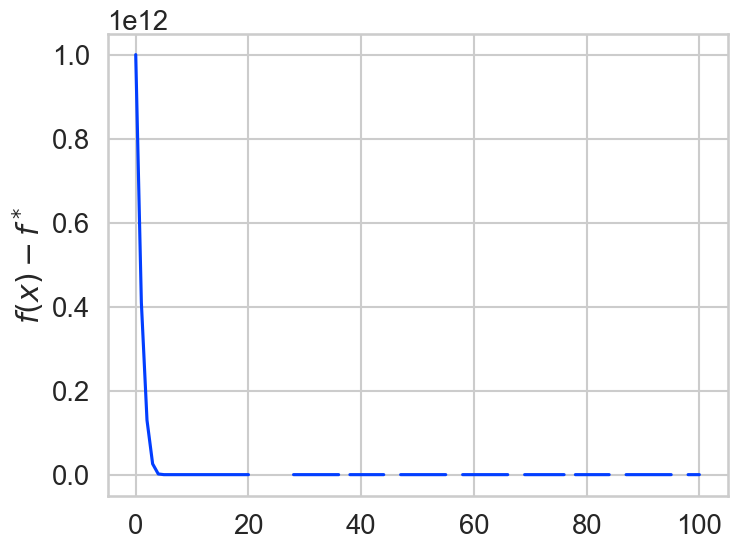

In [37]:
gd_trace.plot_losses(f_opt)

### with fixed step size

In [156]:
gd_lr = 1e-7

In [157]:
gd = GD(
    lr=gd_lr,
    trace_len=n_epochs,
    loss=loss,
    it_max=n_epochs
)
gd_trace = gd.run(x0=x0)
gd_trace.convert_its_to_epochs(batch_size=loss.n)
gd_trace.compute_loss_of_iterates()
# gd_trace.save(f'c_{clip_level}_lr_{step_size}_gd_{n_epochs}', 
                    # trace_dir)

In [127]:
best_gd_trace = gd_trace

# Plots

## Only GD

/Users/postrou/Documents/mbzuai/clipped_random_reshuffling/src/optimizers/traces/stochastic_trace.py:98: RuntimeWarning: divide by zero encountered in log
  y_log = [np.log(loss_vals-f_opt) for loss_vals in self.loss_vals_all.values()]
/Users/postrou/Documents/mbzuai/clipped_random_reshuffling/src/optimizers/traces/stochastic_trace.py:98: RuntimeWarning: invalid value encountered in log
  y_log = [np.log(loss_vals-f_opt) for loss_vals in self.loss_vals_all.values()]
/Users/postrou/miniconda3/envs/crr/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


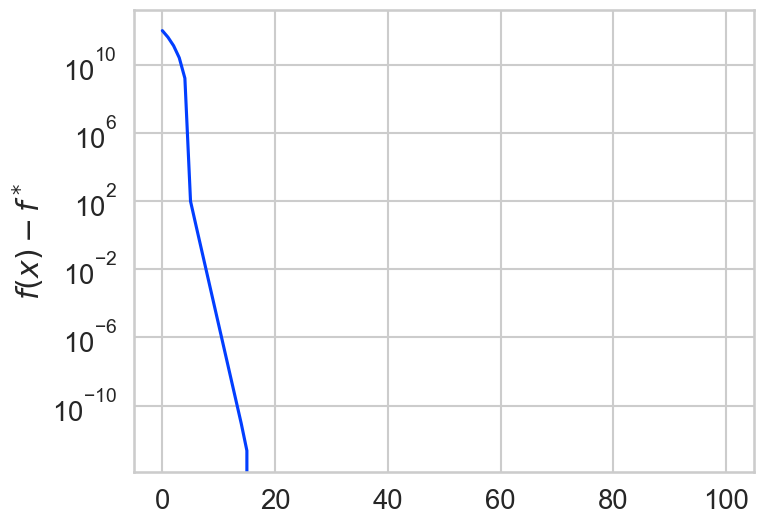

In [20]:
best_gd_trace.plot_losses(f_opt=f_opt)
plt.yscale('log')

## Functional residual

In [32]:
trace_dir, plot_path

('results/fourth_order/x0_1000.0/bs_32/', 'plots/fourth_order/x0_1000.0/bs_32')

In [240]:
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

### Best results

In [33]:
plot_path

'plots/fourth_order/x0_1000.0/bs_32'

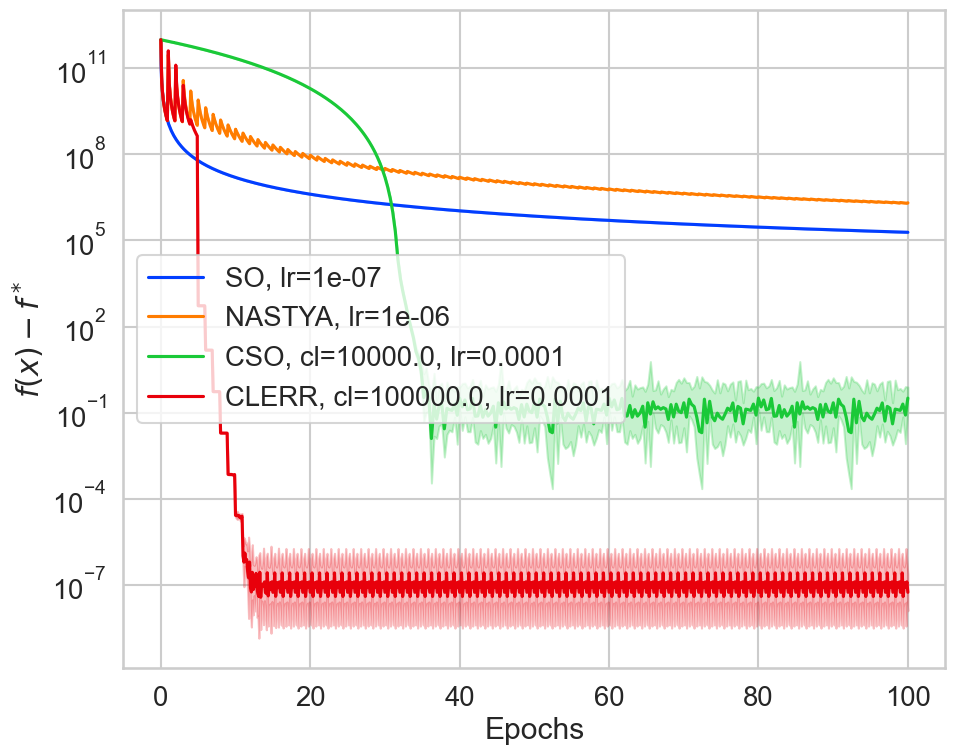

In [34]:
fig = plt.figure(figsize=(10, 8))
traces = [best_so_trace, best_nastya_trace, best_crr_trace, best_clerr_g_trace]
labels = [
    f'SO, lr={best_so_trace.step_size}', 
    f'NASTYA, lr={best_nastya_trace.step_size}',
    f'CSO, cl={best_crr_trace.clip_level}, lr={best_crr_trace.step_size}', 
    f'CLERR, cl={best_clerr_g_trace.clip_level}, lr={best_crr_trace.step_size}'
]
markers = [',', ',', ',', ',', ',', ',']
for trace, label, marker in zip(traces, labels, markers):
    trace.plot_losses(f_opt=f_opt, label=label, marker=marker)
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
# plt.title(f'inner_lr={in_step_size}')
fig.tight_layout()
plt.savefig('plots/clerr/fourth_order.png', bbox_inches='tight')
# plt.savefig(os.path.join(plot_path, f'{dataset}_func.png'))

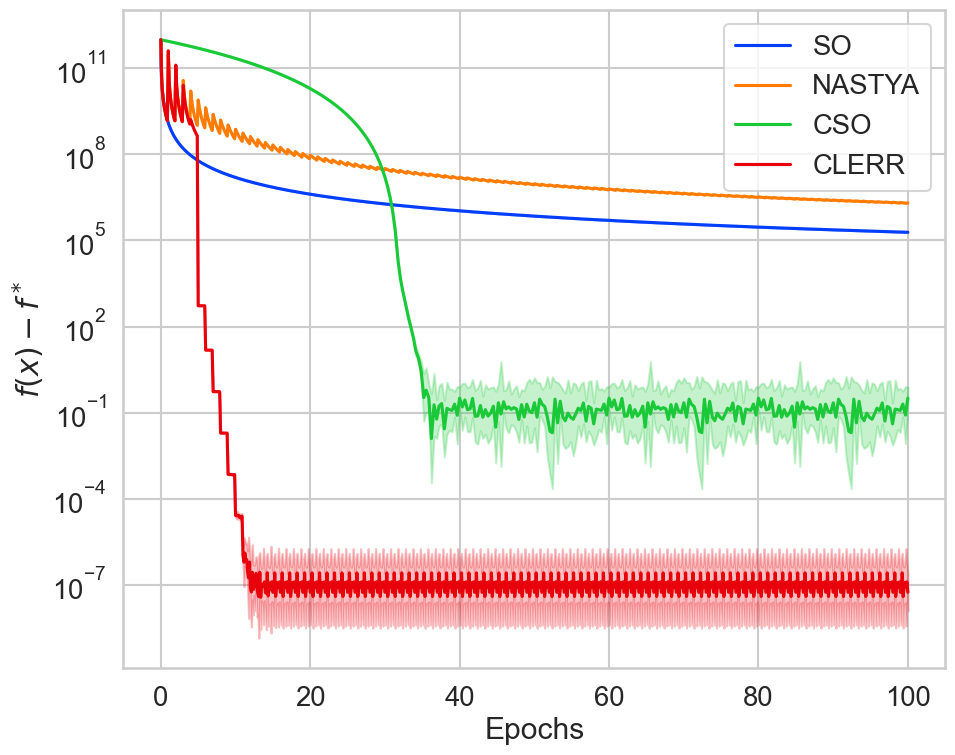

In [35]:
fig = plt.figure(figsize=(10, 8))
traces = [best_so_trace, best_nastya_trace, best_crr_trace, best_clerr_g_trace]
labels = [
    f'SO', 
    f'NASTYA',
    f'CSO', 
    f'CLERR'
]
markers = [',', ',', ',', ',', ',', ',']
for trace, label, marker in zip(traces, labels, markers):
    trace.plot_losses(f_opt=f_opt, label=label, marker=marker)
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
# plt.title(f'inner_lr={in_step_size}')
fig.tight_layout()
plt.savefig('plots/clerr/fourth_order_no_params.png', bbox_inches='tight')
# plt.savefig(os.path.join(plot_path, f'{dataset}_func.png'))